# FAST-UAV - Multirotor Design Optimization with Off-The-Shelf components

In this notebook, we will see how to achieve a design optimization using real off-the-shelf components instead of estimation models.

## 1. Setting up a problem with off-the-shelf components

In [1]:
import os.path as pth
import openmdao.api as om
import logging
import shutil
import fastoad.api as oad
from time import time
import matplotlib.pyplot as plt
import cma
from fastuav.utils.drivers.cmaes_driver import CMAESDriver
from fastuav.utils.postprocessing.analysis_and_plots import *

plt.rcParams["figure.figsize"] = 16, 8
plt.rcParams.update({"font.size": 13})

DATA_FOLDER_PATH = "../data"
CONFIGURATIONS_FOLDER_PATH = "../configurations"
WORK_FOLDER_PATH = "./workdir"

CONFIGURATION_FILE = pth.join(WORK_FOLDER_PATH, "multirotor_mdo_discrete.yaml")
SOURCE_FILE = pth.join(DATA_FOLDER_PATH, "problem_outputs_DJI_M600_mdo.xml")

# For having log messages display on screen
logging.basicConfig(level=logging.INFO, format="%(levelname)-8s: %(message)s")

# For using all screen width
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
oad.generate_configuration_file(
    CONFIGURATION_FILE, overwrite=True, distribution_name="fastuav", sample_file_name="multirotor_mdo_discrete.yaml"
)

INFO    : Loading FAST-OAD plugin uav
INFO    : Loading bundles from fastuav.models
INFO    : Installed bundle fastuav.models.performance.mission.mission_definition.tests.test_schema (ID 29 )
INFO    : Installed bundle fastuav.models.propulsion.propeller.__init__ (ID 69 )
INFO    : Installed bundle fastuav.models.structures.structures_fixedwing_obsolete (ID 100 )
INFO    : Installed bundle fastuav.models.performance.mission.mission_definition.schema (ID 28 )
INFO    : Installed bundle fastuav.models.propulsion.motor.performance_analysis (ID 59 )
INFO    : Installed bundle fastuav.models.stability.static_longitudinal.neutral_point (ID 94 )
INFO    : Installed bundle fastuav.models.aerodynamics.aerodynamics_hybrid (ID 13 )
INFO    : Installed bundle fastuav.models.propulsion.propulsion (ID 70 )
INFO    : Installed bundle fastuav.models.structures.structures_hybrid (ID 101 )
INFO    : Installed bundle fastuav.models.aerodynamics.__init__ (ID 15 )
INFO    : Installed bundle fastuav.models.

'D:\\THESE\\Tools\\FAST-UAV\\src\\fastuav\\notebooks\\workdir\\multirotor_mdo_discrete.yaml'

The changes in the model rely in the use of catalogues instead of continuous estimation models to select the components. This is described in the configuration file by the `off_the_shelf` option when defining the model:

```yaml
model:
    scenarios:
        id: fastuav.scenarios.multirotor
    propulsion:
        id: fastuav.propulsion.multirotor
        off_the_shelf_propeller: True
```

You can check with the N2 diagram visualization that the `catalogue_selection` module has replaced the `skip_catalogue_selection` module for components where the option has been set to True.

In [3]:
N2_FILE = pth.join(WORK_FOLDER_PATH, "n2.html")
oad.write_n2(CONFIGURATION_FILE, N2_FILE, overwrite=True)
from IPython.display import IFrame
IFrame(src=N2_FILE, width="100%", height="500px")

INFO    : N2 diagram written in D:\THESE\Tools\FAST-UAV\src\fastuav\notebooks\workdir\n2.html


Now, the problem outputs from the design optimization in the continuous domain will be re-used as an initial guess for the optimization in the discrete domain.

In [4]:
oad.generate_inputs(CONFIGURATION_FILE, SOURCE_FILE, overwrite=True)

INFO    : Problem inputs written in D:\THESE\Tools\FAST-UAV\src\fastuav\notebooks\workdir\problem_inputs.xml


'D:\\THESE\\Tools\\FAST-UAV\\src\\fastuav\\notebooks\\workdir\\problem_inputs.xml'

In [5]:
INPUT_FILE = pth.join(WORK_FOLDER_PATH, "problem_inputs.xml")
oad.variable_viewer(INPUT_FILE)

## 2. Multirotor MDO with off-the-shelf components

Due to the non-continuous nature of the selection process, the use of a gradient-based algorithm is risky. We therefore recommend the use of an evolutionary algorithm, [CMA-ES](http://www.cmap.polytechnique.fr/~nikolaus.hansen/cmaesintro.html).

### a) Using a gradient-based algorithm: SLSQP

In [6]:
optim_problem = oad.optimize_problem(CONFIGURATION_FILE, overwrite=True)

ERROR   : Optimization failed after 35.23 seconds
INFO    : Problem outputs written in D:\THESE\Tools\FAST-UAV\src\fastuav\notebooks\workdir\problem_outputs.xml


Iteration limit reached    (Exit mode 9)
            Current function value: [1.29906109]
            Iterations: 200
            Function evaluations: 2180
            Gradient evaluations: 200
Optimization FAILED.
Iteration limit reached
-----------------------------------


In [ ]:
# conf = oad.FASTOADProblemConfigurator(CONFIGURATION_FILE)
# prob = conf.get_problem(read_inputs=True, auto_scaling=True)
# prob.setup()
# prob.check_partials(compact_print=True, show_only_incorrect=True, abs_err_tol=1e-05, rel_err_tol=1e-05)

### b) Using an evolutionnary strategy: CMA-ES
The [pycma](https://github.com/CMA-ES/pycma) implementation of CMA-ES is used. The optimizer is wrapped with a modified version of the [OpenMDAO driver](https://github.com/OpenMDAO/RevHack2020/tree/master/problems/cma_es).<br>

*Note that the use of custom-made drivers is not supported yet by FAST-OAD. Consequently, the setup and run of the problem is made by hand.*

(5_w,11)-aCMA-ES (mu_w=3.4,w_1=42%) in dimension 12 (seed=904821, Fri Oct 14 14:40:56 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     11 3.001263987139096e+06 1.0e+00 9.80e-02  9e-02  1e-01 0:00.1
    2     22 2.779369157280223e+06 1.2e+00 9.73e-02  9e-02  1e-01 0:00.2
    3     33 2.370656725858571e+06 1.2e+00 1.17e-01  1e-01  1e-01 0:00.4
   31    341 8.038952177284147e+05 3.7e+00 3.64e-01  2e-01  6e-01 0:03.4
   68    748 2.928712237068156e+05 7.9e+00 1.92e-01  7e-02  4e-01 0:07.5
  100   1100 1.420598388897871e+05 1.5e+01 1.09e-01  2e-02  2e-01 0:11.0
  155   1705 1.303447361062834e+03 5.3e+01 3.87e-02  3e-03  8e-02 0:17.0
  200   2200 2.091279499145335e+00 1.1e+02 2.76e-02  1e-03  5e-02 0:21.7
  278   3058 1.690574573929035e+00 2.4e+02 2.87e-02  8e-04  6e-02 0:29.7
  300   3300 1.649505992604498e+00 3.1e+02 2.43e-02  6e-04  5e-02 0:32.0
  397   4367 1.566881107610476e+00 3.5e+02 1.38e-02  2e-04  3e-02 0:42.0
  400   4400 1.567255508565192e+0

D:\Softwares\poetry\cache\virtualenvs\fastuav-qz6dlUbG-py3.8\lib\site-packages\cma\utilities\utils.py:343: UserWarning: CAVE: restart_from_best is often not useful ()
  warnings.warn(msg + ' (' +


Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1   7448 1.276150013243640e+05 1.0e+00 9.99e-02  9e-02  1e-01 0:00.3
    2   7470 1.316839349641808e+05 1.3e+00 9.39e-02  9e-02  1e-01 0:00.6
    3   7492 1.433282957198732e+05 1.4e+00 9.08e-02  8e-02  1e-01 0:00.8
   16   7778 2.626962765696131e+04 3.2e+00 4.59e-02  2e-02  5e-02 0:03.9
   32   8130 4.546999519822567e+03 7.6e+00 4.04e-02  7e-03  5e-02 0:08.0
   53   8592 2.276940348707996e+03 2.5e+01 3.15e-02  2e-03  4e-02 0:13.0
   78   9142 1.699839090213699e+00 1.1e+02 2.84e-02  1e-03  5e-02 0:19.1
  100   9626 1.620630099702612e+00 1.7e+02 2.83e-02  6e-04  5e-02 0:24.6
  134  10374 1.577927136757573e+00 2.4e+02 2.80e-02  4e-04  5e-02 0:32.6
  172  11210 1.565111229548014e+00 3.3e+02 1.81e-02  2e-04  4e-02 0:41.7
  200  11826 1.563290529813165e+00 3.0e+02 7.84e-03  8e-05  1e-02 0:48.6
  243  12772 1.562935214556079e+00 3.3e+02 2.74e-03  2e-05  4e-03 0:59.7
  275  13476 1.562905033596075e+00 3.5e+02 6.58e-04 

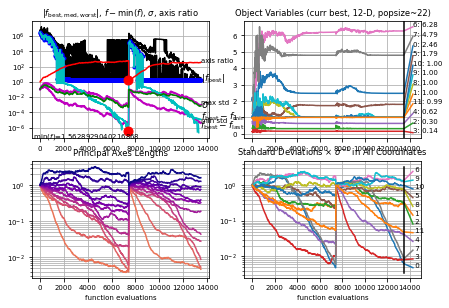

In [12]:
# Get problem configuration
conf = oad.FASTOADProblemConfigurator(CONFIGURATION_FILE)
prob = conf.get_problem(read_inputs=True, auto_scaling=True)

# CMA-ES Driver setup (see cma.CMAOptions() for all possible options for CMA-ES)
driver = prob.driver = CMAESDriver()
driver.options["sigma0"] = 0.1
driver.options[
    "penalty_parameter"
] = 1.0e6  # should be chosen such that f and the constraints violation have a similar magnitude.
driver.options["penalty_exponent"] = 1.0
driver.options["restarts"] = 1
driver.options["restart_from_best"] = True
driver.options["bipop"] = False
driver.CMAOptions["tolfun"] = 1e-6
driver.CMAOptions["tolfunhist"] = 1e-5
driver.CMAOptions["popsize_factor"] = 1
# driver.CMAOptions['CMA_stds'] = [1, 1, 100, 0.1, 0.1, 1, 1, 1, 1]
# driver.CMAOptions['CSA_dampfac'] = 1.  # positive multiplier for step-size damping
# driver.CMAOptions['CSA_squared'] = True
# driver.CMAOptions['integer_variables'] = [2]
# driver.options['augmented_lagrangian'] = True  # whether to use penalty method or augmented lagrangian for handling constraints

# Setup and run problem
prob.setup()
start_time = time()
prob.optim_failed = prob.run_driver()  # optimize
end_time = time()
computation_time = round(end_time - start_time, 2)
prob.write_outputs()

print("Objective function value ", driver.get_objective_values())

logger = cma.plot()  # plot logger

Let's save and visualize the optimization results:

In [10]:
OUTPUT_FILE = pth.join(WORK_FOLDER_PATH, "problem_outputs.xml")
DJI_M600_OUTPUT_FILE = pth.join(DATA_FOLDER_PATH, "problem_outputs_discrete_DJI_M600_mdo.xml")
shutil.copy(OUTPUT_FILE, DJI_M600_OUTPUT_FILE)
oad.optimization_viewer(CONFIGURATION_FILE)

D:\Softwares\poetry\cache\virtualenvs\fastuav-qz6dlUbG-py3.8\lib\site-packages\jupyter_client\session.py:718: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


### oad.variable_viewer(OUTPUT_FILE)

## 3. Analysis and plots

We may now compare the results from the optimization in the continuous domain with the off-the-shelf configuration:

In [ ]:
OUTPUT_FILE_CONTINUOUS = pth.join(DATA_FOLDER_PATH, "problem_outputs_DJI_M600_mdo.xml")
OUTPUT_FILE_DISCRETE = pth.join(DATA_FOLDER_PATH, "problem_outputs_discrete_DJI_M600_mdo.xml")
fig = multirotor_geometry_plot(OUTPUT_FILE_CONTINUOUS, name="Drone custom")
fig = multirotor_geometry_plot(OUTPUT_FILE_DISCRETE, name="Drone off-the-shelf", fig=fig)
fig.show()

In [ ]:
fig = mass_breakdown_sun_plot_drone(OUTPUT_FILE_DISCRETE)
fig.show()

In [ ]:
#fig = mass_breakdown_bar_plot_drone(OUTPUT_FILE_CONTINUOUS, name="Drone custom")
#fig = mass_breakdown_bar_plot_drone(OUTPUT_FILE_DISCRETE, name="Drone off-the-shelf", fig=fig)
#fig.show()